In [1]:
# import packages
import pandas as pd
import numpy as np

from sklearn.linear_model import Ridge, ElasticNet
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option("display.max_columns", None)

In [60]:
# Read csv file
df = pd.read_csv('dataset/job_contracts_dataset.csv')
df.head()


,wp_id,wp_status,business_model,company_id,company_name,wp_starts_on,wp_ends_on,job_function,candidate_id,candidate_name,total_gross,est_total_gross,issue_reported,contract_type,gross_wage_amount,gross_wage_time_unit,work_period_unit,work_period_amount,work_period_hours,fee_percentage,is_cancelled
0,1723992,upcoming,staffing_agency,299204747,Hurst-Garcia,2020-04-01,2020-04-30,support-guy,49285305,Kenneth Price,1114.285714,1114.285714,False,full_time,650,hour,month,2.0,40.0,3.92,0
1,4706480,paid,staffing_agency,168767792,Peterson-Wilson,2017-10-01,2017-10-31,f1-guy,57564699,Susan Jensen,1061.660000,1041.660000,False,full_time,104166,month,month,12.0,40.0,5.00,0
2,5002046,paid,staffing_agency,146877029,Adams LLC,2017-08-01,2017-08-28,f1-guy,52752416,Christie Keller,664.280000,1031.968000,False,full_time,110568,month,month,1.6,40.0,0.00,0
3,6879092,payslip_generated,staffing_agency,396877181,Gonzales-Zuniga,2016-11-01,2016-11-30,editor,41650643,Bradley Barron,1058.280000,1042.760000,False,full_time,104276,month,month,3.0,40.0,10.00,0
4,3278989,paid,staffing_agency,28940115,Davies LLC,2018-01-01,2018-01-10,f1-guy,57648833,Kathy Mathews,554.940000,419.446667,False,full_time,125834,month,month,12.0,40.0,0.00,1


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14125 entries, 0 to 14124
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   wp_id                 14125 non-null  int64  
 1   wp_status             14125 non-null  object 
 2   business_model        14125 non-null  object 
 3   company_id            14125 non-null  int64  
 4   company_name          14125 non-null  object 
 5   wp_starts_on          14125 non-null  object 
 6   wp_ends_on            14125 non-null  object 
 7   job_function          14125 non-null  object 
 8   candidate_id          14125 non-null  int64  
 9   candidate_name        14125 non-null  object 
 10  total_gross           14125 non-null  float64
 11  est_total_gross       14125 non-null  float64
 12  issue_reported        14125 non-null  bool   
 13  contract_type         14125 non-null  object 
 14  gross_wage_amount     14125 non-null  int64  
 15  gross_wage_time_uni

<font color='blue'> 
__What df.info() tells us__  
    </font>
There are no missing values in the dataset as df.info() suggests.  
Also, we have multiple data types within the columns that will later be transformed.  
Next, the describe() function is applied to check distribution of respective columns:

In [62]:
# describe df to check distribution of numerical columns and detect possible issues
df.describe()

,wp_id,company_id,candidate_id,total_gross,est_total_gross,gross_wage_amount,work_period_amount,work_period_hours,fee_percentage,is_cancelled
count,1.412500e+04,1.412500e+04,1.412500e+04,14125.000000,14125.000000,14125.000000,14125.000000,14125.000000,14125.000000,14125.000000
mean,3.982254e+06,2.806616e+08,5.471279e+07,901.460886,871.649018,84587.754619,9.384612,33.137027,4.732677,0.329345
std,2.305371e+06,1.591639e+08,7.647798e+06,594.240973,578.676573,68669.124029,11.346158,11.235131,3.478055,0.469992
min,7.730000e+02,2.641165e+06,1.358000e+04,-30.810000,-368.342857,500.000000,-9.200000,1.000000,0.000000,0.000000
25%,1.980253e+06,1.468770e+08,5.511102e+07,375.000000,353.245000,898.000000,3.000000,30.000000,1.700000,0.000000
50%,3.980127e+06,2.628645e+08,5.764168e+07,981.000000,981.000000,105426.000000,5.000000,40.000000,5.000000,0.000000
75%,5.996166e+06,4.428450e+08,5.777155e+07,1265.640000,1258.300000,125834.000000,12.000000,40.000000,6.000000,1.000000
max,7.981365e+06,5.581467e+08,5.794367e+07,7484.571429,7484.571429,500000.000000,72.900000,51.000000,43.300000,1.000000


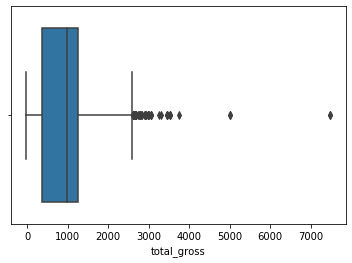

In [63]:
# Create a boxplot to check for outliers in target variable
sns.boxplot(df['total_gross'])

In [64]:
# Isolated values of total gross are present, use mean & standard deviation as a threshold to remove them
mean = df['total_gross'].mean()
std = df['total_gross'].std()
threshold = mean + 6*std
df = df.loc[df['total_gross'] < threshold] 

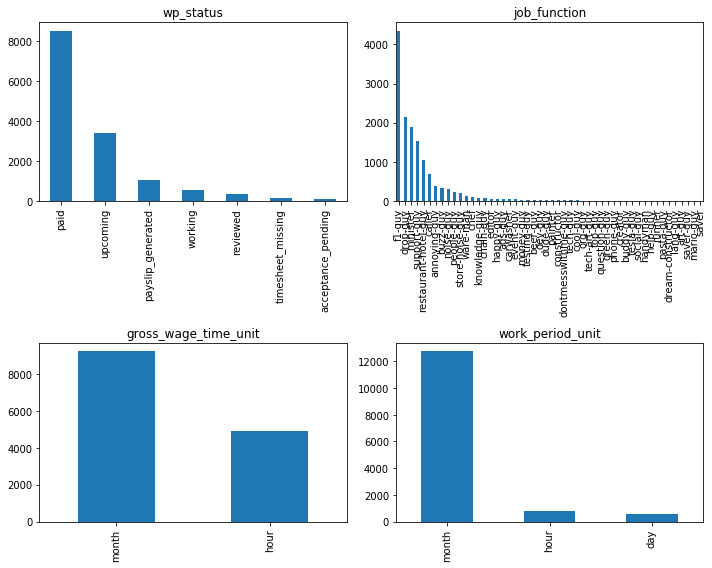

In [65]:
# Explore some of the categorical variables to check # of categories and frequency

fig, axs = plt.subplots(2, 2,figsize=(10,8))

df['wp_status'].value_counts().plot(kind='bar', ax=axs[0,0], title='wp_status')
df['job_function'].value_counts().plot(kind='bar', ax=axs[0,1], title = 'job_function')
df['gross_wage_time_unit'].value_counts().plot(kind='bar', ax=axs[1,0], title='gross_wage_time_unit')
df['work_period_unit'].value_counts().plot(kind='bar', ax=axs[1,1], title='work_period_unit')
plt.tight_layout()

<font color='blue'> 
__How to manipulate categorical columns?__  
    </font>

The above columns are not ordinal and thus we could apply one-hot encoding.  
Nonetheless, since there are more than 3 categories per categorical column (except for gross_wage_time_unit), this would result in significant dimensionality increase in the feature space.  
Therefore, label-encoding will be applied instead, and then standard scaling along with the numerical columns.

<font color='blue'> 
__The following preprocessing steps are performed in the next code blocks:__
    </font>
- Convert start/end date columns to datetime format and extract new feature (duration)
- Convert a few categorical features to numerical ones using labelEncoder
- Remove rows where either total_gross or est_total_gross are negative 


In [66]:
# Convert date columns to datetime format
df['wp_starts_on'] = pd.to_datetime(df['wp_starts_on'])
df['wp_ends_on'] = pd.to_datetime(df['wp_ends_on'])

# Create new feature: duration of work period in days
df['duration'] = (df['wp_ends_on']-df['wp_starts_on']).dt.days

# encode categorical features that may be related to target column
labEnc = LabelEncoder()
for col in ['wp_status','job_function','gross_wage_time_unit','work_period_unit']:
    df[col] = labEnc.fit_transform(df[col])

# Assumption made: Negative total_gross column should not be included because negative salary doesn't make sense
df = df.loc[df['total_gross']>=0]


In [67]:
# The 'est_total_gross' column will be used as a baseline model to compare with the model we will develop
baseline = df[['est_total_gross']]
df.drop('est_total_gross', axis=1, inplace=True)

<font color='blue'> 
__Explore correlations between columns__  
    </font>
We compute the correlation matrix of the dataframe to check for linear dependencies among the columns.  
The respective heatmap suggests that there is strong correlation (corr > 0.5) between the target column (total_gross) and the following columns:  
- duration
- work_period_hours
- gross_wage_amount  

The above information gives some insights, but feature selection is discussed later.

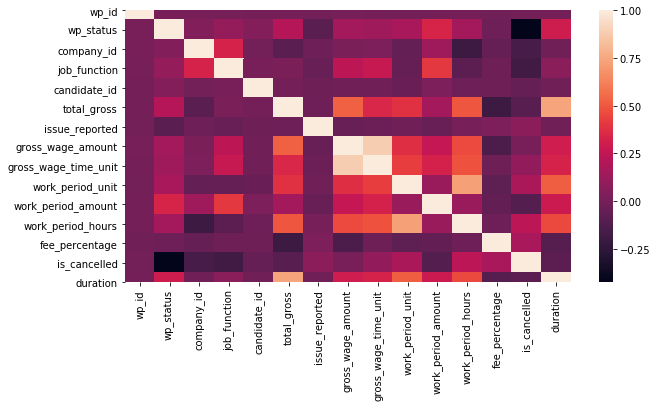

In [51]:
# calculate correlation matrix and plot heatmap
cormat = df.corr()

fig, ax = plt.subplots(figsize=(10,5)) 
sns.heatmap(df.corr(),ax=ax)

<font color='blue'> 
__Design Training and Testing phase__  
    </font>
To start experimenting with algorithms, we first divide the dataset to 67%-33%, where the 67% will be used for training & testing, and the 33% will be used for validation respectively.  
The first set (67%) will be further split to multiple training-test sets within a cross validation process.  



In [71]:
# Drop columns that seem to hold no important information
X_all = df.drop(['total_gross','wp_id','business_model','wp_starts_on','wp_ends_on',
              'issue_reported','company_id','company_name','contract_type','candidate_name'],axis=1)
y_all = df['total_gross']

# Split dataframe to Train/Test(X,y) and Validation(X_val,y_val) sets
X, X_val, y, y_val = train_test_split(X_all, y_all, test_size=0.30, random_state=42)

# Select the same indices from baseline array to compare the results later
y_baseline = baseline.loc[y_val.index]


<font color='blue'> 
__Design model selection process__  
</font>
- A standard scaling will be applied to the dataset
- Regarding the feature selection process, instead of arbitarily choosing a specific number of features with sklearn functions such as SelectKBest, we will perform data transformation with PCA. 
- A Bayesian hyperoptimization process will be followed to explore various models and find best parameters

The steps of the model selection pipeline are the following:  
1. Define search spaces for each algorithm (we will explore Ridge regression, ElasticNet, SVR and RandomForest)
2. Define search space for PCA (number of components)
3. For each model select a subset of parameters and perform the steps:
    - Apply standard scaling
    - Apply PCA
    - Create a 10-fold cross validation
    - Compute the cv average error (we use root mean squared error as metric)

<font color='blue'>     
__Justification of error metric selection__  
</font>
Root mean squared error is selected here, because it is easy to interpret (in contrast to mse), while it still has the advantage of penalizing large prediction errors, as inherited by mse. 


In [12]:
def objective(parameters):
    kf = KFold(n_splits=10)
    mdl=parameters[0]['mdl']().set_params(**parameters[1])
#     mdl = mdl.set_params(**parameters[1])
    loss = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Use standard scaler to transform training set, then apply scaling to test set
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        
        # Perform PCA analysis to select components 
        pca = PCA(**parameters[2])
        X_train = pca.fit_transform(X_train)
        X_test = pca.transform(X_test)
        
        # train with selected model and predict test set
        mdl = mdl.fit(X_train, y_train)
        y_pred = mdl.predict(X_test)
        
        #calculate loss for each fold
        loss.append(sqrt(mean_squared_error(y_test, y_pred)))
        
    return {'loss': np.mean(loss), 'parameters': parameters, 'status': STATUS_OK}


# Define the space to search for best hyperparameters
spaceRidge = [{'mdl':Ridge},
              { 'solver': hp.choice('solver',['svd', 'cholesky', 'lsqr']),
                'normalize': hp.choice('normalize',[True,False]),
                'alpha': hp.choice('alpha',[0.1, 1, 10, 100]),
                'fit_intercept': hp.choice('fit_intercept',[True,False]),
                'random_state':42},
              {'n_components' : hp.choice('n_components',list(range(3,X.shape[1]+1,1)))}
              ]


spaceElastic = [{'mdl':ElasticNet},
                {'max_iter': hp.choice('max_iter',[1, 5, 10]),
                 'alpha': hp.choice('alpha',[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]),
                 'l1_ratio': hp.choice('l1_ratio',np.arange(0.0, 1.0, 0.1)),
                'random_state':42},
                {'n_components' : hp.choice('n_components',list(range(3,X.shape[1]+1,1)))}
    ]

spaceSVR = [{'mdl':SVR},
           {'kernel':'rbf',
           'C':hp.choice('C',[0.1, 1, 10, 100]),
           'gamma':hp.choice('gamma',[1e-2,1e-1,1])},
            {'n_components' : hp.choice('n_components',list(range(3,X.shape[1]+1,1)))}
           ]

spaceRF = [{'mdl':RandomForestRegressor},
           {'n_estimators':hp.choice('n_estimators',[50,100,150]),
            'max_depth':hp.choice('learning_rate',list(range(10,100,20))),
            'min_samples_split': hp.choice('min_samples_split',[2, 5, 10]),
            'random_state':42},
           {'n_components' : hp.choice('n_components',list(range(3,X.shape[1]+1,1)))}
            ]


# Put spaces to a list to iterate
spaces = [spaceRidge, spaceElastic,spaceRF,spaceSVR]
estimators = ['Ridge','ElasticNet','SVR']

best_spaces = []
best_losses = []

for i in range(len(spaces)):
    
    space = spaces[i]
    print('Searching model ',str(space[0]['mdl']))
    trials = Trials()
    best = fmin(fn=objective, space=space, algo=tpe.suggest, trials=trials, max_evals=30)
    best_trial = sorted(trials.results, key=lambda x: x['loss'])
    
    best_spaces.append(best_trial[0]['parameters'])
    best_losses.append(best_trial[0]['loss'])
    
    

Searching model  <class 'sklearn.linear_model._ridge.Ridge'>
100%|██████████| 30/30 [00:14<00:00,  2.08trial/s, best loss: 246.58110384877236]
Searching model  <class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
100%|██████████| 30/30 [00:12<00:00,  2.38trial/s, best loss: 246.58098016833188]
Searching model  <class 'sklearn.ensemble._forest.RandomForestRegressor'>
100%|██████████| 30/30 [47:04<00:00, 94.14s/trial, best loss: 171.92029414914253] 
Searching model  <class 'sklearn.svm._classes.SVR'>
100%|██████████| 30/30 [1:02:03<00:00, 124.11s/trial, best loss: 228.46905293463118]


<font color='blue'> 
__Select best model__  
</font>
After the search is over, we select the model with the best (minimum) loss.  
We create an instance of the selected algorithm and pass the parameters that were found to be the best performing.  
The preprocessing steps (scaling and PCA) and the model are then applied to the entire dataset X,y which is the final training set.  
After applying the same preprocessing steps to the validation set (X_val, y_val), we make the prediction for the latter.


In [72]:
# Print best loss and find index of best model
print('Best loss from model selection process:',np.min(best_losses))
ind = np.argmin(best_losses)

# Get best parameters from the search 
n_components = best_spaces[ind][2]['n_components']
params = best_spaces[ind][1]
mdl = best_spaces[ind][0]['mdl']()
mdl.set_params(**params)

# Fit training data to StabdardScaler, then transform X_val 
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_val = scaler.transform(X_val)

# Fit training data to PCA, then transform X_val 
pca = PCA(n_components)
X = pca.fit_transform(X)
X_val = pca.transform(X_val)

# Fit model to training data, then predict X_val 
mdl.fit(X,y)
y_pred = mdl.predict(X_val)

Best loss from model selection process: 171.92029414914253


In [73]:
# Compare prediction error of selected model and baseline model

print('Prediction error on validation set:',sqrt(mean_squared_error(y_val, y_pred)))
print('Prediction error on baseline set:',sqrt(mean_squared_error(y_val, y_baseline['est_total_gross'].to_numpy())))

Prediction error on validation set: 179.65169897570013
Prediction error on baseline set: 182.24450550417356


<font color='blue'>

### __The results on the validation set indicate that the model we developed outperforms the baseline model.__ </font>


Text(0.5, 1.0, 'Scatter plot of true VS predicted values')

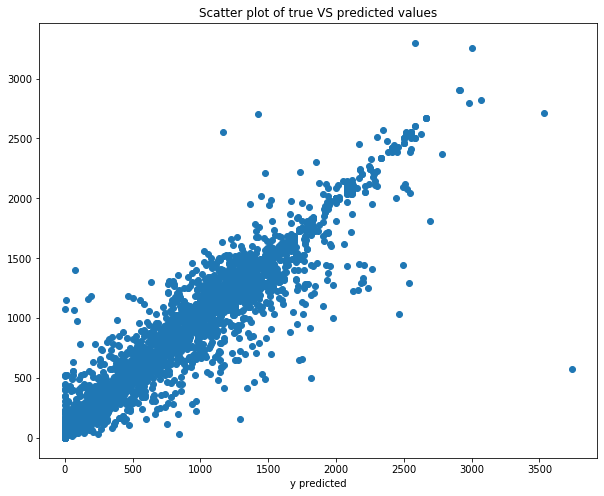

In [74]:
# Create a scatter plot to visualize how weel the prediction was with respect to the real data
fig = plt.figure(figsize=[10,8])
plt.scatter(y_val,y_pred)
plt.xlabel('y true')
plt.xlabel('y predicted')
plt.title('Scatter plot of true VS predicted values')

__Discussion on implementation__  

- The above approach was followed based on some assumptions that were made with regards to the features. Deeper understanding of some of the columns may assist in deciding to follow a different feature selection process.  
- Regarding the model selection process with the bayesian hyperoptimization, 4 algorithms that represent different categories of regression were chosen (linear methods, ensemble regressors, support vector machines).  
- Getting the model ready for production would require to consider some aspects first, such as:
    1. Scalability of the algorithm. How often will the model run and for how many instances?
    2. Maybe re-training is needed after a while to ensure that as historical data might change, the algorithm will kepp track of that and be up to date.
    3. Getting feedback from the model's performance would be useful to adapt the algorithm so that it performs better.